# Previsão de Churn - Aprendizado de Máquina
___
**Churn**, também chamado de *churn rate* ou *attrition rate*, é uma métrica que mede a evasão de clientes de determinada empresa, ou seja, a taxa de cancelamento. Ou seja, caso a taxa de evasão seja alta, quer dizer que os clientes estão insatisfeitos com a empresa, e que há algum problema que deve ser tratado. Nesse caso, o notebook trata de um dataset fictício de um banco visando previsão de churns.

### O problema de negócio
___
O [Dataset](https://www.kaggle.com/mervetorkan/churndataset?select=churn.csv) apresenta 10.000 instâncias com dados fictícios de um banco que atua na Europa, com 14 atributos diversos acerca de clientes como nome, pontuação de crédito, salário estimado, se possui ou não cartão de crédito, entre outros, e por fim, se existiu evasão ou não por parte do cliente i.e. churn. 

A taxa média de churn é claramente variável de acordo com o porte e segmento da empresa. No caso do setor bancário, taxas de churn entre 11% a 34% podem ser encontradas [[1]](https://thefinancialbrand.com/59779/digital-banking-branch-channel-switching/). Partindo desse princípio, o notebook apresenta um modelo de aprendizado de máquina de previsão de churn utilizando o dataset pré-processado, bem como análises de faturamento dos classificadores de acordo com o conceito de valor esperado, e valor esperado rankeado com visualização através das curvas de lucro.

### Os dados
___
O [Dataset](https://www.kaggle.com/mervetorkan/churndataset?select=churn.csv) apresenta 10.000 instâncias com dados fictícios de um banco que atua na Europa, com 14 atributos diversos acerca de clientes, sendo que dos quais, após o pré-processamento, foram selecionados:
- Independentes:
    - Variável `Geography` representa o país do cliente
    - Variável `Gender` representa o gênero do cliente
    - Variável `Age` representa a idade do cliente
    - Variável `IsActiveMember` representa a atividade do cliente (se é membro ativo ou não)
    - Variável `Germany_Balance` sendo atributo criado
- Dependentes:
    - Variável `Exited` representa a saída do cliente, i.e churn

- Importar bibliotecas:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings as wn

wn.filterwarnings('ignore')

plt.style.use('ggplot')

- Ler o dataset, mostrar as 5 primeiras linhas:

In [2]:
df = pd.read_csv('churn_preprocessing.csv', index_col='CustomerId')

In [3]:
df.head()

,Geography,Gender,IsActiveMember,Age,Germany_Balance,Exited
CustomerId,,,,,,
15634602,France,Female,1,42,0,1
15647311,Spain,Female,1,41,0,0
15619304,France,Female,0,42,0,1
15701354,France,Female,0,39,0,0
15737888,Spain,Female,1,43,0,0


# 1. Pré-processamento
____

- Get dummy variables

In [4]:
df = pd.get_dummies(df, columns=['Geography','Gender'])

In [5]:
df.head()

,IsActiveMember,Age,Germany_Balance,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
CustomerId,,,,,,,,,
15634602,1,42,0,1,1,0,0,1,0
15647311,1,41,0,0,0,0,1,1,0
15619304,0,42,0,1,1,0,0,1,0
15701354,0,39,0,0,1,0,0,1,0
15737888,1,43,0,0,0,0,1,1,0


- Split dataset em treino e teste:

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop('Exited', axis=1)
y = np.array(df['Exited'])
indices = np.arange(X.shape[0])

In [8]:
x_train, x_test, y_train, y_test, idx1, idx2 = train_test_split(X, y, indices, test_size=0.3)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7000, 8), (3000, 8), (7000,), (3000,))

In [10]:
idx1_df = df.iloc[idx1,:].index
idx2_df = df.iloc[idx2,:].index

# 2. Aprendizado de Máquina
____

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve

As métricas de avaliação dos modelos foram:

- Precision: de todos os clientes que o modelo previu churn, quantos deles realmente saíram?
$$ Precision = \frac{TP}{(TP+FP)} $$


- Recall: % de clientes previstos para churn que o modelo previu corretamente?
$$ Recall = \frac{TP}{(TP+FN)}$$


- F1: medida relativa de precision e recall (média harmônica):
$$ F_1 = \frac{TP}{(TP + \frac{1}{2}(FP+FN))}$$


- ROC-AUC: relação entre taxas de TP e FP, sendo que a AUC (área sob a curva) sumariza a ROC em um único número (quão mais próxima de 1, melhor o classificador em relação á taxa de falsos positivos).

onde TP$\to$true positive, FP$\to$false positive (erro tipo I), e FN$\to$false negative (erro tipo II)

### Avaliação em função do problema de negócio
___
A priori, temos como resultado do modelo de classificação a matriz de confusão, que apresenta os seguintes valores:

- TP: previsão de churn, que realmente ocorre $\to$ perda monetária pois cliente sai
- TN: previsão de não churn, que realmente ocorre $\to$ sem perda monetária, pois cliente permanece
- FP: previsão de churn, mas cliente não sai $\to$ sem perda monetária, pois cliente permanece
- FN: previsão de não churn, mas cliente sai $\to$ perda monetária, pois previu que cliente ficaria e ele saiu

Até tal ponto, é possível compreender as previsões, porém não dentro de um contexto de negócio. Faz-se necessário então aplicar um conceito bastante utilizado onde pode-se concatenar as previsões do modelo de aprendizado de máquina com valores do negócio - conceito de **valor esperado**:

$$EV = p(o_1)v(o_1) + p(o_2)v(o_2) + ...$$

onde $p(o_i)$ é a probabilidade do evento, e $v(o_i)$ é seu valor.

Nesse contexto, visando calcular o valor esperado de lucro de uma campanha de retenção de clientes, pode-se realizar uma análise de curso-benefício, onde temos TP e TN como benefícios (modelo previu corretamente), e FP e FN como os custos (modelo previu incorretamente). A matriz de custo-benefício utilizada para avaliação do projeto com valores fictícios foi baseada em [[2]](https://carmenlai.com/2016/11/12/user-churn-prediction-a-machine-learning-workflow.html). Nesse escopo, foi assumido que caso o modelo preveja churn, o plano de retenção terá um gasto de \\$150 com o cliente. Se o plano tiver sucesso na retenção, o lucro será do lifetime value do cliente menos o custo com o próprio plano, nesse caso, \\$325 - \\$150 = \\$175, simplificando custos com FP e TN:

- TP $\to$ benefício $\to$ \\$175 - cliente responde positivamente à campanha e tinha intenção de churn

- FN $\to$ custo $\to$ -$150 - cliente não responde positivamente à campanha e não ocorre retenção

Portanto, pode-se calcular o valor esperado como:

$$EV_{profit} = [p(Y|1)b(Y,1) + p(N|1)c(N,1)] + [p(N|0)b(N,0) + p(Y|0)c(Y,0)] $$

Entretanto, é importante também levar em consideração a probabilidade de se encontrar cada classe *a priori*, ou seja, a probabilidade *a priori* de ocorrer churn ou não [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/), ou seja, $p(0)$ ou $p(ñ churn)$ e $p(1)$ ou $p(churn)$, principalmente para classes desbalanceadas. Assim, temos que:

$$EV_{profit} = p(1)*[p(Y|1)b(Y,1) + p(N|1)c(N,1)] + $$
$$p(0)*[p(N|0)b(N,0) + p(Y|0)c(Y,0)] $$

onde:
- p $\to$ probabilidade
- b e c $\to$ benefício e custo
- 0 e 1 $\to$ não churn e churn
- N e Y $\to$ previsão de não churn e churn

O valor esperado de lucro pode ser expresso, portanto, como:

$$EV_{profit} = 0.2037*[175(Y|1) - 150(N|1)] + 0.7963*[0p(N|0) + 0p(Y|0)] \to$$

$$\to EV_{profit} = 35.64p(Y|1) - 30.55p(N|1)$$

Nota-se que são considerados apenas as ocorrências de churn, sendo considerados TP e FN e, como consequência, valores de recall culminarão em maior lucro esperado.

In [12]:
# matriz de custo-benefício
cb = np.array([[0,0],[-150, 175]])
              
pd.DataFrame(np.array([[0,0],[-150, 175]]), index=['True_0','True_1'], 
             columns=['Pred_0','Pred_1'])

,Pred_0,Pred_1
True_0,0,0
True_1,-150,175


In [13]:
# probabilidade de churn e não churn
p_0 = df.query('Exited==0').shape[0]/df.shape[0]
p_1 = df.query('Exited==1').shape[0]/df.shape[0]
p_0, p_1

(0.7963, 0.2037)

### 2.1. Baseline: Decision Stump
___

**Decision Stump** é uma estratégia na qual se escolhe o único e mais informativo atributo presente entre as os preditores e baser todas as decisões neste atributo. No presente caso, utiliza-se uma árvore de decisão com somente um nó interno, ou seja, o nó raiz (*root node*), onde a árvore de decisão seleciona um único atributo com maior ganho de informação para a decisão [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/).

Nota-se pela matriz de confusão abaixo que o modelo classificou todas as instâncias como classe majoritária, ou seja, entre 3000 instâncias, sendo que 2408 da Classe 0 (`Exited`=0) e 592 da Class 1 (`Exited`=1), o modelo classificou corretamente todas as instâncias da Classe 0, e classificou incorretamente todas as instâncias da Classe 1, atribuindo-as à Classe 0 $\to$ classificador majoritário com *ROC-AUC score* de 0.65.

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
# baseline
dt = DecisionTreeClassifier(max_depth=1, random_state=42)

dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

In [16]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
dt_results = cross_val_score(dt, x_train, y_train, cv=kfold)
dt_results.mean()

0.7962857142857143

In [17]:
# predição
dt_predict = dt.predict(x_test)
dt_proba = dt.predict_proba(x_test)[:,1]

In [18]:
# métricas de comparação
print('Precision:',precision_score(y_test, dt_predict))
print('Recall:',recall_score(y_test, dt_predict))
print('F1:',f1_score(y_test, dt_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, dt_proba))

Precision: 0.0
Recall: 0.0
F1: 0.7060457722521185
ROC-AUC: 0.6874600511482319


In [19]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, dt_predict))

,0,1
0,2389,0
1,611,0


### 2.2 - Regressão Logística
___
A regressão logística é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas, sendo um modelo de fácil explicação e rápido. Mais em [[4]](https://github.com/renan2scarvalho/Applied-Data-Science-with-Python/blob/master/3%20Applied%20Machine%20Learning%20in%20Python/cesarian.ipynb).

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
# modelo
lr = LogisticRegression(class_weight='balanced',random_state=42,n_jobs=-1)

lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)

In [22]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
lr_results = cross_val_score(lr, x_train, y_train, cv=kfold)
lr_results.mean()

0.7137142857142857

In [23]:
# predição
lr_predict = lr.predict(x_test)
lr_proba = lr.predict_proba(x_test)[:,1]

In [24]:
# métricas
print('Precision:',precision_score(y_test, lr_predict))
print('Recall:',recall_score(y_test, lr_predict))
print('F1:',f1_score(y_test, lr_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, lr_proba))

Precision: 0.39569691300280635
Recall: 0.6923076923076923
F1: 0.7451574735449735
ROC-AUC: 0.7716021810274725


In [25]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, lr_predict))

,0,1
0,1743,646
1,188,423


### 2.3. Random Forest
___
Random Forests é um conjunto de Árvores de Decisão com Bootstrap Aggregation (bagging), onde as árvores são executadas em paralelo, o que significa que não há interação entre elas. Mais em [[4]](https://github.com/renan2scarvalho/Applied-Data-Science-with-Python/blob/master/3%20Applied%20Machine%20Learning%20in%20Python/cesarian.ipynb).

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# classificador
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

rfc.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [28]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
rfc_results = cross_val_score(rfc, x_train, y_train, cv=kfold)
rfc_results.mean()

0.7462857142857143

In [29]:
# predição
rfc_predict = rfc.predict(x_test)
rfc_proba = rfc.predict_proba(x_test)[:,1]

In [30]:
# métricas
print('Precision:',precision_score(y_test, rfc_predict))
print('Recall:',recall_score(y_test, rfc_predict))
print('F1:',f1_score(y_test, rfc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, rfc_proba))

Precision: 0.4180602006688963
Recall: 0.613747954173486
F1: 0.763249618734711
ROC-AUC: 0.7519773183008045


In [31]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, rfc_predict))

,0,1
0,1867,522
1,236,375


### 2.4. Gradient Boosting
___
O algoritmo Gradient Boosting usa um conjunto de árvores individuais (weak learners) em série para atingir um strong learner. Aqui, as árvores são conectadas em série, de modo que a próxima árvore foque em consertar os erros do anterior (atua como um feedback). Um grande número de árvores, neste caso, pode levar a um overfitting, mas se ajustado corretamente, pode ser mais preciso do que o algoritmo Random Forests. Mais em [[4]](https://github.com/renan2scarvalho/Applied-Data-Science-with-Python/blob/master/3%20Applied%20Machine%20Learning%20in%20Python/cesarian.ipynb).

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

In [33]:
# modelo
gbc = GradientBoostingClassifier(random_state=42, )

gbc.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [34]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
gbc_results = cross_val_score(gbc, x_train, y_train, cv=kfold)
gbc_results.mean()

0.8352857142857143

In [35]:
# predição
gbc_predict = gbc.predict(x_test)
gbc_proba = gbc.predict_proba(x_test)[:,1]

In [36]:
# métricas
print('Precision:',precision_score(y_test, gbc_predict))
print('Recall:',recall_score(y_test, gbc_predict))
print('F1:',f1_score(y_test, gbc_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, gbc_proba))

Precision: 0.7012987012987013
Recall: 0.353518821603928
F1: 0.8157458005840388
ROC-AUC: 0.7996477307682032


In [37]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, gbc_predict))

,0,1
0,2297,92
1,395,216


### 2.6. Extreme Gradient Boosting (XGBoost)
___
Similar ao algoritmo Gradient Boosting, mas com alguns diferenciais, como melhor penalização das árvores de decisão, encolhimento proporcional dos nós, dentre outros, sendo computacionalmente eficiente (rápido na execução) e altamente efetivo. Mais em [[5]](https://en.wikipedia.org/wiki/XGBoost), [[6]](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/).

Um valor arbitrário de *scale_pos_weight* foi utilizado devido às classes desbalanceadas [[7]](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

In [38]:
from xgboost.sklearn import XGBClassifier

In [39]:
# desbalanço
spw = round(np.unique(y_train, return_counts=True)[1][0]/np.unique(y_train, return_counts=True)[1][1])
spw

4

In [40]:
# modelo
xgb = XGBClassifier(scale_pos_weight=spw, random_state=42, n_jobs=-1)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
xgb_results = cross_val_score(xgb, x_train, y_train, cv=kfold)
xgb_results.mean()

0.7312857142857143

In [42]:
# predição
xgb_predict = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)[:,1]

In [43]:
# métricas
print('Precision:',precision_score(y_test, xgb_predict))
print('Recall:',recall_score(y_test, xgb_predict))
print('F1:',f1_score(y_test, xgb_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, xgb_proba))

Precision: 0.40784313725490196
Recall: 0.6808510638297872
F1: 0.7545941148356939
ROC-AUC: 0.7814721592898164


In [44]:
# matriz de confusão
pd.DataFrame(confusion_matrix(y_test, xgb_predict))

,0,1
0,1785,604
1,195,416


# 3. Avaliação

___

## 3.1. Métricas
___

Pelas figuras que apresentam a matriz de confusão normalizada abaixo, nota-se que o modelo de regressão logística apresentou uma taxa de TP ligeiramente superior ao algoritmo XGBoost, como também uma menor taxa de FN, ambos valores representado na linha inferior da matriz de confusão. Como resultado temos um maior valor de recall para ambos os algoritmos.

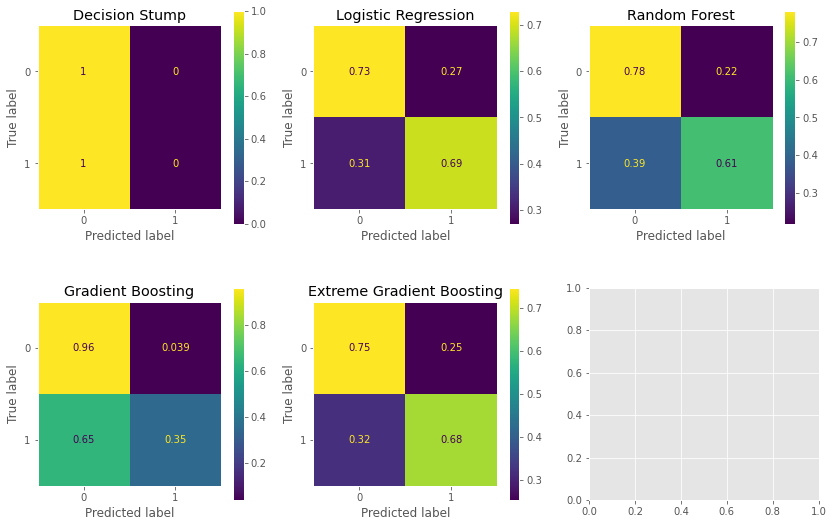

In [45]:
# confusion matrix normalized
fig, [[ax0,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=(14,9))
plot_confusion_matrix(dt, x_test, y_test, normalize='true', ax=ax0)
ax0.set(title='Decision Stump')
plot_confusion_matrix(lr, x_test, y_test, normalize='true', ax=ax1)
ax1.set(title='Logistic Regression')
plot_confusion_matrix(rfc, x_test, y_test, normalize='true', ax=ax2)
ax2.set(title='Random Forest')
plot_confusion_matrix(gbc, x_test, y_test, normalize='true', ax=ax3)
ax3.set(title='Gradient Boosting')
plot_confusion_matrix(xgb, x_test, y_test, normalize='true', ax=ax4)
ax4.set(title='Extreme Gradient Boosting')

for ax in [ax0,ax1,ax2,ax3,ax4]:
    ax.grid(False)
    
plt.subplots_adjust(hspace=0.3)

A curva ROC é uma forma gráfica de revisar o desempenho dos modelos de classificação, sendo um bom indicador de desempenho, especialmente porque estamos interessados na taxa de TP dos modelos. A área sob a curva (AUC) mede a capacidade do modelo de classificar corretamente aqueles que tiveram evasão, e os que não tiveram. Quanto maior a AUC, melhor o classificador em relação à taxa de TP.

Abaixo, vemos que o modelo Gradient Boosting apresentou o maior valor de AUC, seguido pelos classificadores XGBoost e Regressão Logística, e por fim Random Forest. Nesse contexto, como os modelos de Regressão Logística e XGBoost apresentaram bons resultados de AUC, TP e baixa taxa de FN, principais métricas dentro do problema de negócio, como comentado acima, ambos serão considerados abaixo.

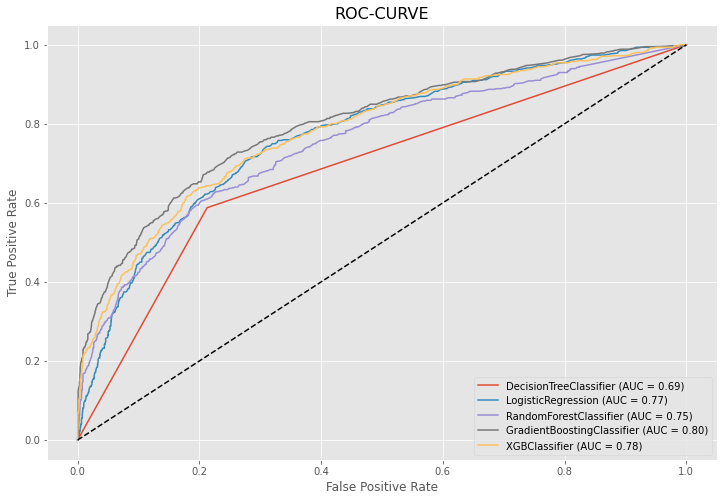

In [46]:
# ROC-AUC
fig, ax=plt.subplots(figsize=(12,8))
plot_roc_curve(dt, x_test, y_test, ax=ax)
plot_roc_curve(lr, x_test, y_test, ax=ax)
plot_roc_curve(rfc, x_test, y_test, ax=ax)
plot_roc_curve(gbc, x_test, y_test, ax=ax)
plot_roc_curve(xgb, x_test, y_test, ax=ax)
ax.plot([0,1], [0,1], linestyle='--', color='k')
plt.title('ROC-CURVE', size=16);

## 3.2. Ajuste de hiperparâmetros
___
No aprendizado de máquina, os hiperparâmetros são parâmetros cujos valores são utilizados no processo de aprendizado, tendo influência, portanto, na performance do modelo, influenciando no tempo e qualidade do processo de aprendizagem [[7]](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)).

Nesse contexto, nos passos a seguir, foram selecionados os modelos de Regressão Logística e XGBoost para ajuste de hiperparâmetros e reavaliação em função do problema de negócio $\to$ recall tem maior impacto no lucro esperado e, portanto, o ajuste dos hiperparâmetros será em função de tal métrica.

### Regressão Logística
___
Para o algoritmo de regressão logística, quando utilizado regularização, é melhor que se normalize os valores das variáveis [[8]](https://www.dataschool.io/comparing-supervised-learning-algorithms/).

- Normalizar o dataset ($\mu$=0 e $\sigma$=1)

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

In [48]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [85]:
# parâmetros para random search
C = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['newton-cg','liblinear','lbfgs']
penalty = ['l1','l2']
params = dict(C=C, solver=solver, penalty=penalty)

# classificador
clf = LogisticRegression(class_weight='balanced', random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='recall', 
                            cv = kfold,
                            n_jobs=-1, 
                            verbose=1).fit(x_train_sc, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.001}

In [86]:
# modelo
lr = LogisticRegression(solver='liblinear',C=0.001,penalty='l1',
                        class_weight='balanced',random_state=42,n_jobs=-1)

lr.fit(x_train_sc, y_train)

LogisticRegression(C=0.001, class_weight='balanced', n_jobs=-1, penalty='l1',
                   random_state=42, solver='liblinear')

In [87]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
lr_results = cross_val_score(lr, x_train_sc, y_train, cv=kfold, scoring='recall')
lr_results.mean()

0.7449027501150225

In [88]:
# predição
lr_predict = lr.predict(x_test_sc)
lr_proba = lr.predict_proba(x_test_sc)[:,1]

In [89]:
# métricas
print('Precision:',precision_score(y_test, lr_predict))
print('Recall:',recall_score(y_test, lr_predict))
print('F1:',f1_score(y_test, lr_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, lr_proba))

Precision: 0.3353204172876304
Recall: 0.7364975450081833
F1: 0.6829887918341971
ROC-AUC: 0.734630011118883


In [90]:
# matriz de confusão
lr_cm = confusion_matrix(y_test, lr_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, lr_predict))

,0,1
0,1497,892
1,161,450


### XGBoost
___

In [72]:
# parâmetros para random search
n_estimators = [50, 100, 300, 500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5]
subsample = [0.5, 0.8, 1]
max_depth = [3, 5, 8, 10]
gamma = [0, 0.1, 0.5]
min_child_weight = [1, 3, 5]
colsample_bytree = [0.5, 0.8, 1]
scale_pos_weight = [3, 4, 5, 8]
params = dict(n_estimators=n_estimators, 
              learning_rate=learning_rate, 
              subsample=subsample,
              max_depth=max_depth,
              gamma=gamma,
              min_child_weight=min_child_weight,
              colsample_bytree=colsample_bytree,
              scale_pos_weight=scale_pos_weight)

# classificador
clf = XGBClassifier(random_state=42)

# search
kfold = KFold(n_splits=10, random_state=42)
search = RandomizedSearchCV(clf, 
                            params, 
                            scoring='roc_auc', 
                            cv=kfold,
                            verbose=1, 
                            n_jobs=-1).fit(x_train, y_train)

# avaliar parâmetros
search.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.7s finished


{'subsample': 0.5,
 'scale_pos_weight': 4,
 'n_estimators': 300,
 'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.05,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [73]:
# modelo
xgb = XGBClassifier(subsample=0.5,
                     scale_pos_weight=4,
                     n_estimators=300,
                     min_child_weight=3,
                     max_depth=3,
                     learning_rate=0.05,
                     gamma=0.5,
                     colsample_bytree=0.8)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
# avaliar modelo
kfold = KFold(n_splits=10, random_state=42)
xgb_results = cross_val_score(xgb, x_train, y_train, cv=kfold, scoring='recall')
xgb_results.mean()

0.7024273205693289

In [75]:
# predição
xgb_predict = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)[:,1]

In [69]:
# métricas
print('Precision:',precision_score(y_test, xgb_predict))
print('Recall:',recall_score(y_test, xgb_predict))
print('F1:',f1_score(y_test, xgb_predict, average='weighted'))
print('ROC-AUC:',roc_auc_score(y_test, xgb_proba))

Precision: 0.4814340588988476
Recall: 0.6153846153846154
F1: 0.795758301404853
ROC-AUC: 0.7983282625837599


In [76]:
# matriz de confusão
xgb_cm = confusion_matrix(y_test, xgb_predict, normalize='true')
pd.DataFrame(confusion_matrix(y_test, xgb_predict))

,0,1
0,1813,576
1,178,433


### Comparação
___
O modelo de regressão logística apresentou uma maior taxa de TP (0.74) e uma menor taxa de FN (0.26), enquanto o modelo XGBoost apresentou uma menor taxa de TP (0.71) e maior taxa de FN (0.29). De maneira geral, ambos os modelos apresentaram melhorias nos parâmetros TP e FN. Portanto, de acordo com o problema de negócio, o modelo de regressão logística apresenta uma melhor performance.

Nota-se também que, quando os parâmetros foram ajustados, o valor de AUC para o modelo XGBoost aumentou de 0.78 para 0.8 enquanto o modelo de regressão logística teve redução de 0.77 para 0.73 devido ao scoring utilizado (recall), com redução de TN e aumento de FP.

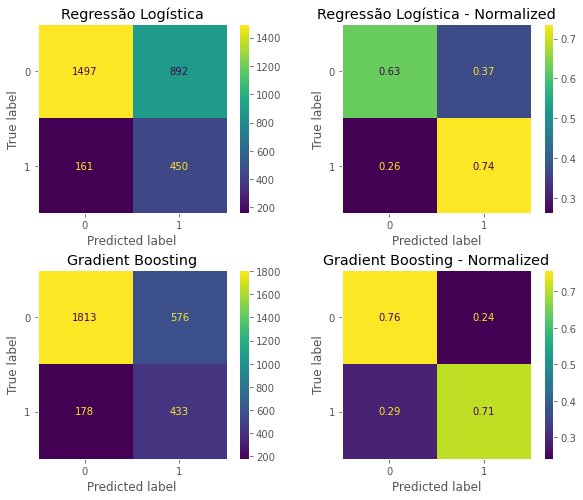

In [91]:
# matriz de confusão
# regressão logística
fig, [[ax0,ax1],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=.3)
plot_confusion_matrix(lr, x_test_sc, y_test, ax=ax0)
ax0.grid(False)
ax0.set(title='Regressão Logística')
plot_confusion_matrix(lr, x_test_sc, y_test, normalize='true',ax=ax1)
ax1.grid(False)
ax1.set(title='Regressão Logística - Normalized')
# GB
plot_confusion_matrix(xgb, x_test, y_test, ax=ax3)
ax3.grid(False)
ax3.set(title='Gradient Boosting')
plot_confusion_matrix(xgb, x_test, y_test, normalize='true',ax=ax4)
ax4.grid(False)
ax4.set(title='Gradient Boosting - Normalized');

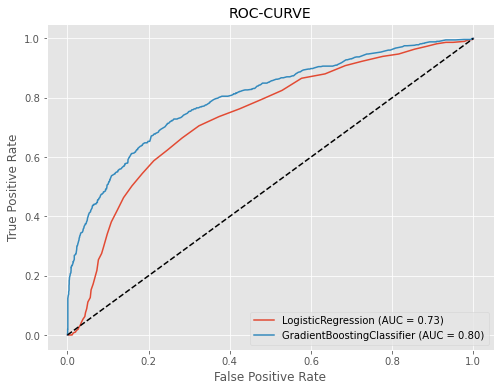

In [92]:
# ROC-AUC
fig, ax=plt.subplots(figsize=(8,6))
plot_roc_curve(lr, x_test_sc, y_test, ax=ax)
plot_roc_curve(gbc, x_test, y_test, ax=ax)
ax.plot([0,1], [0,1], linestyle='--', color='k')
plt.title('ROC-CURVE', size=14);

## 3.2. Lucro Esperado
___
Entretanto, quando aplicada a equação de valor esperado de lucro mencionada acima, foi possível calcular o valor esperado em função da performance dos classificadores e da matriz de custo-benefício, ou seja, considerando tanto os aspectos técnicos do classificador quanto o plano de retenção de clientes. 

Nota-se que o classficador com maior valor esperado é o modelo SVM, seguido pela Regressão Logística e Gradient Boosting, ou seja, utilizando o plano de retenção de clientes indicado no início, os três modelos comentados apresentariam lucro esperado positivo. Isso porque, como indicado, o modelo apresenta uma menor taxa de FN, a qual como apresentado na equação, é capaz de reduzir o valor esperado significativamente.

In [93]:
print('Regressão Logística - Lucro Esperado: ${}'.format(
    round(
        p_1*((lr_cm[1][1]*cb[1][1]) + (lr_cm[1][0]*cb[1][0])) + 
        p_0*((lr_cm[0][0]*cb[0][0]) + (lr_cm[0][1]*cb[0][1])),
        2)
    )
)

Regressão Logística - Lucro Esperado: $18.2


In [95]:
print('Gradient Boosting - Lucro Esperado: ${}'.format(
    round(
        p_1*((xgb_cm[1][1]*cb[1][1]) + (xgb_cm[1][0]*cb[1][0])) + 
        p_0*((xgb_cm[0][0]*cb[0][0]) + (xgb_cm[0][1]*cb[0][1])),
        2)
    )
)

Gradient Boosting - Lucro Esperado: $16.36


### 3.2.1. Curvas de Lucro Esperado
___
Entretanto, uma estragégia diferente para a tomada de decisão pode ser o rankeamento das instâncias de acordo com seu score de churn, ou seja, sua probabilidade, onde, através dos resultados e visualização da curva das instâncias rankeadas por score, pode-se escolher determinado número $n$ de clientes para aplicar o plano de retenção, de acordo com o lucro máximo apresentado por cada classificador, como é também possível adaptar o plano de retenção com restrições orçamentárias para outro determinado número $n$ de clientes.

Mais especificamente, a classificação por rankeamento produz uma lista de instâncias e seus scores de probabilidade de forma decrescente, calculando-se o valor esperado resultando para cada instância da lista. Como é possível notar abaixo, a curva de lucro pode ser negativa, especialmente quando a margem de lucro é pequena e o número de clientes que o programa de retenção consegue atingir é também pequeno [[3]](https://www.oreilly.com/library/view/data-science-for/9781449374273/). Diferentemente do valor esperado calculado anteriormente, o qual considera os valores totais do classificador, no caso da curva de valor esperado os valores de TP, TN, FP, FN mudam a cada e instância e, portanto, seu valor esperado.

In [96]:
df_cost = pd.DataFrame(y_test, index=idx2_df, columns=['y_true'])

In [97]:
def calculate_metrics(df):
    
    """Calcula tp, tn, fp, fn, FPR, gain, valor esperado e % de instâncias"""
    
    df['tp']=0
    df['tn']=0
    df['fp']=0
    df['fn']=0
    df['EV'] = 0
    df['Perc Instances'] = 0
    
    tp_aux,tn_aux,fp_aux,fn_aux = 0,0,0,0

    for i in range(df.shape[0]):

        # Calcular tp, tn, fp, fn
        if df.iloc[i,0]==1 and df.iloc[i,1]==1: # churn -> tp
            tp_aux+=1
            df.iloc[i,3] = tp_aux

        elif df.iloc[i,0]==0 and df.iloc[i,1]==0: # no churn -> tn
            tn_aux+=1
            df.iloc[i,4] = tn_aux

        elif df.iloc[i,0]==0 and df.iloc[i,1]==1: # fp
            fp_aux+=1
            lr_cost.iloc[i,5] = fp_aux

        elif df.iloc[i,0]==1 and df.iloc[i,1]==0: # fn
            fn_aux+=1
            df.iloc[i,6] = fn_aux
           
        # Calcular valor esperado
        cm = [[tn_aux, fp_aux], [fn_aux, tp_aux]]
        df.iloc[i,7] = sum(sum(cm * cb)) / df.shape[0]
        
        # Calcular porcentagem de instâncias
        df.iloc[i,8] = (i+1)/df.shape[0]

### Regressão Logística
____

In [98]:
lr_cost = df_cost.copy()
lr_cost['predict'] = lr_predict
lr_cost['proba'] = lr_proba
lr_cost = lr_cost.sort_values(by='proba', ascending=False)

In [99]:
calculate_metrics(lr_cost)

### Gradient Boosting
___

In [101]:
xgb_cost = df_cost.copy()
xgb_cost['predict'] = xgb_predict
xgb_cost['proba'] = xgb_proba
xgb_cost = xgb_cost.sort_values(by='proba', ascending=False)

In [102]:
calculate_metrics(xgb_cost)

Nota-se pelas curvas de lucro que o lucro máximo de \\$26.25 obtido é pelo modelo de Regressão Logística com 44.9% do número de instâncias de teste, o que representa 1347 clientes. Já o modelo XGBoost teve lucro esperado máximo de \\$25.26 com 33.5% do total de instâncias, o que representa 1006 clientes. 

Nesse contexto, analisando as curvas, nota-se que o modeo XGBoost apresenta um lucro esperado superior com uma menor quantidade de clientes.
Já no caso do modelo de Regressão Logística, se obtém um lucro esperado superior, porém com uma maior porcentagem de instâncias dos clientes. Essa análise é interessante justamente por tal fato, pois de acordo com o orçamento disponível, pode-se escolher o modelo que será mais eficaz em relação ao lucro esperado para a empresa.

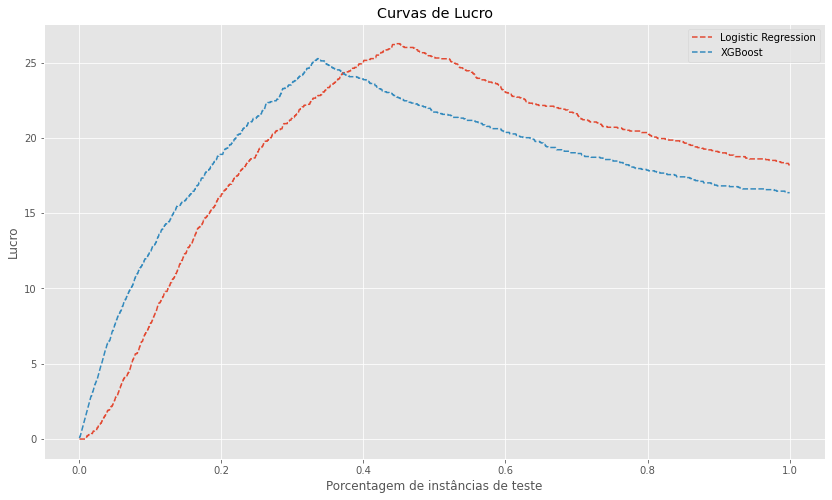

In [103]:
fig, ax=plt.subplots(figsize=(14,8))
ax.plot(lr_cost['Perc Instances'],lr_cost['EV'], linestyle='--', label='Logistic Regression')
ax.plot(xgb_cost['Perc Instances'],xgb_cost['EV'], linestyle='--', label='XGBoost')
plt.legend()
ax.set(title='Curvas de Lucro', xlabel='Porcentagem de instâncias de teste',
      ylabel='Lucro');

In [104]:
print('Regressão Logística: Lucro máximo esperado de ${} com {}% das instâncias ({} clientes)'.format(
    lr_cost.sort_values(by='EV', ascending=False).head(1)['EV'].values[0],
    lr_cost.sort_values(by='EV', ascending=False).head(1)['Perc Instances'].values[0]*100,
    (lr_cost.sort_values(by='EV', ascending=False).head(1)['Perc Instances'].values*lr_cost.shape[0])[0])
)

Regressão Logística: Lucro máximo esperado de $26.25 com 44.9% das instâncias (1347.0 clientes)


In [106]:
print('XGBoost: Lucro máximo esperado de ${} com {}% das instâncias ({} clientes)'.format(
    xgb_cost.sort_values(by='EV', ascending=False).head(1)['EV'].values[0],
    xgb_cost.sort_values(by='EV', ascending=False).head(1)['Perc Instances'].values[0]*100,
    (xgb_cost.sort_values(by='EV', ascending=False).head(1)['Perc Instances'].values*xgb_cost.shape[0])[0])
)

XGBoost: Lucro máximo esperado de $25.258333333333333 com 33.53333333333333% das instâncias (1006.0 clientes)


### 3.2.2. Constrained Budget
___
Considerando o caso em que se possui uma restrição orçamentária para a campanha de retenção, como, por exemplo \\$45000. Nesse caso, como casa oferta de retenção custa \\$150, temos que:

$$ n_{ofertas} = \frac{orçamento}{custo} = \frac{\\$45000}{\\$150} = 300$$

Nesse escopo, teríamos que a porcentagem de instâncias de teste seria $n_{ofertas}/n_{clientes} \to 300/3000 \to $10%, o classificador Gradient Boosting apresenta o maio lucro esperado, como visto abaixo e comentado acima.

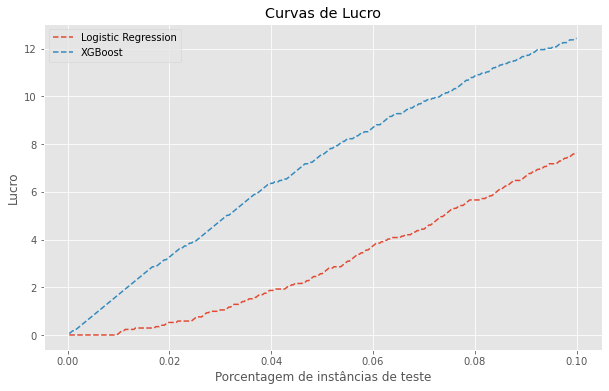

In [107]:
fig, ax=plt.subplots(figsize=(10,6))
ax.plot(lr_cost['Perc Instances'][:300],lr_cost['EV'][:300], linestyle='--', label='Logistic Regression')
ax.plot(xgb_cost['Perc Instances'][:300],xgb_cost['EV'][:300], linestyle='--', label='XGBoost')
plt.legend()
ax.set(title='Curvas de Lucro', xlabel='Porcentagem de instâncias de teste',
      ylabel='Lucro');

# 4. Sumarização
____

Entre as métricas:

- Recall: Regressão Logística
- ROC-AUC: XGBoost
- Valor Esperado: Regressão Logística
- Curvas de Lucro: variável de acordo com budget

Portanto, nota-se que o modelo a ser utilizado pela empresa será variável de acordo com as restrições apresentadas pela própria empresa, pois caso não exista restrição orçamentária, o modelo de Regressão Logística seria o melhor em relação ao lucro esperado. Entretanto, caso exista, um maior escrutínio acerca da porcentagem de instância a serem consideradas é necessário e, portanto, a escolha do modelo pode variar.